# Deep filtering

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
from tensorflow.python.keras import backend

In [3]:
# config = tf.compat.v1.ConfigProto(device_count={'GPU': 1, 'CPU': 6})
config = tf.compat.v1.ConfigProto(device_count={'CPU': 6})
sess = tf.compat.v1.Session(config=config)
backend.set_session(sess)

We consider the basic econometric stochastic volatility model written in the form of a nonlinear state-space model:

* Havey, A. (1990). *Forecasting, Structural Time Series Models and the Kalman Filter.* Cambridge University Press, New York.

This model is no longer state-of-the-art, but we choose to start with something basic.

First, we need some way to sample the parameters. We use the same priors as in

* Meyer, R., Yu, J. (2000). *BUGS for a Bayesian Analysis of Stochastic Volatility Models*.

In [4]:
parameter_count = 3

In [5]:
def generate_parameters():
    precision = .1
    variance = 1. / precision
    std = np.sqrt(variance)
    mu = np.random.normal(loc=0., scale=std)
    phistar = np.random.beta(a=20., b=1.5)
    itau2 = np.random.gamma(shape=2.5, scale=.025)
    beta = np.exp(.5 * mu)
    phi = 2. * phistar - 1.
    tau = np.sqrt(1. / itau2)
    Parameters = collections.namedtuple('Parameters', ['mu', 'phi', 'tau'])
    return Parameters(mu=mu, phi=phi, tau=tau)

Given the parameters, we can generate the latent states $x_0, x_1, \ldots, x_n$:

In [6]:
def generate_xs(parameters, n):
    xs = []
    x0 = np.random.normal(loc=parameters.mu, scale=parameters.tau)
    xs.append(x0)
    for x in range(n):
        x_mean = parameters.mu + parameters.phi * (xs[-1] - parameters.mu)
        x = np.random.normal(loc=x_mean, scale=parameters.tau)
        xs.append(x)
    return np.array(xs)

Given the latent states $x_0, x_1, \ldots, x_n$, we can generate the observations $y_1, y_2, \ldots, y_n$:

In [7]:
def generate_ys(xs):
    return np.array([np.random.normal(loc=0., scale=np.exp(.5 * x)) for x in xs[1:]])

Thus we have the machinery for generating observations using a simple Monte Carlo procedure.

We fix

In [8]:
n = 1000

The neural networks that we will apply will operate on the basis of a sliding window of a given size, which we also fix

In [9]:
window_size = 50

In [10]:
iter_count = 1000

Before we start sampling random combinations of parameters, we fix them as in (Meyer, 2000):

In [11]:
Parameters = collections.namedtuple('Parameters', ['mu', 'phi', 'tau'])
parameters = Parameters(mu=2. * np.log(.7204), phi=.9807, tau=.1489)
parameters

Parameters(mu=-0.655897331360672, phi=0.9807, tau=0.1489)

Let's generate the latent states using these parameters,

In [12]:
xs = generate_xs(parameters, n)

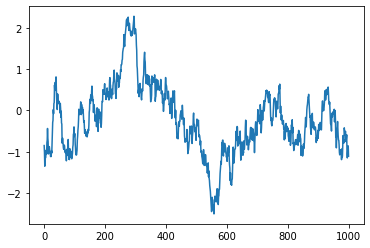

In [13]:
plt.plot(xs);

Given the latent states, we can generate the observations:

In [14]:
ys = generate_ys(xs)

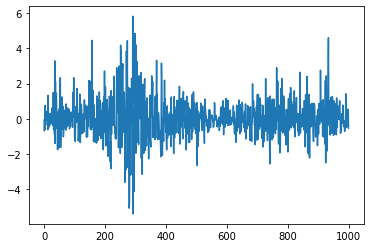

In [15]:
plt.plot(ys);

Our first question is whether, with the parameters fixed, a neural network can replace a particle filter.

We first consider the architecture and procedure described in

* Qing Zhang, George Yin, Leyi Wang (2020). Deep Filtering. https://arxiv.org/abs/2008.03878

In [16]:
model = keras.Sequential()
model.add(keras.layers.Dense(10, activation='sigmoid', input_dim=window_size))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(1, activation='linear'))

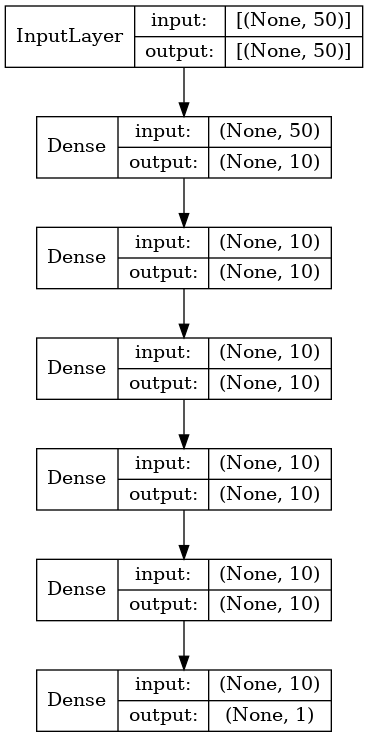

In [17]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

However, we face a problem with this configuration. Let us first check whether this configuration can learn (effectively) the identity function in a trivial filtering problem
$$x_{k+1} = x_k + 1,$$
$$y_k = x_k.$$

In [17]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [18]:
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [19]:
losses = []

In [21]:
xs = np.array(range(0, n+1))
yx = xs[1:]
xs = (xs - np.min(xs)) / (np.max(xs) - np.min(xs)) - .5
ys = (ys - np.min(ys)) / (np.max(ys) - np.min(ys)) - .5
for i in range(iter_count):
    inputs = []
    outputs = []
    for j in range(n - window_size):
        an_input = ys[j:j+window_size]
        inputs.append(an_input)
        an_output = xs[j+window_size]
        outputs.append(an_output)
    the_inputs = np.array(inputs)
    history = model.fit(the_inputs, np.array(outputs))
    losses.append(history.history['loss'][0])

30/30 [==============================] - 0s 730us/step - loss: 0.0754 - mse: 0.0754


Let us check the (in-sample) performance of the above learning procedure:

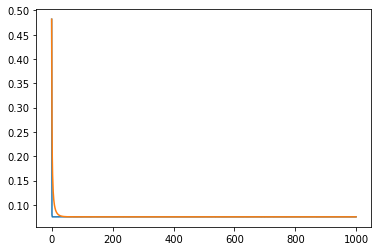

In [23]:
plt.plot(losses)
plt.plot(pd.Series(losses).ewm(alpha=.1).mean());

In [24]:
pred_outputs = []
true_outputs = []
for j in range(n - window_size):
    an_input = np.array([ys[j:j+window_size]])
    an_output = xs[j+window_size]
    true_outputs.append(an_output)
    pred_output = model.predict(an_input)[0]
    pred_outputs.append(pred_output)

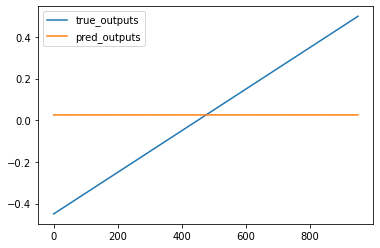

In [25]:
plt.plot(true_outputs, label='true_outputs')
plt.plot(pred_outputs, label='pred_outputs')
plt.legend();

The reason for this problem is known. It is described and analysed in detail in

* Zhang, Bengio, Hardt, Mozer, Singer (2020). Identity Crisis: Memorization and Generalization under Extreme Overparameterization.

"CNNs of up to 10 layers are able to generalize from a single example, whereas FCNs cannot learn the identity function reliably from 60k examples."

Let's, then, try a configuration based on CNNs.

In [18]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)))
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='linear'))

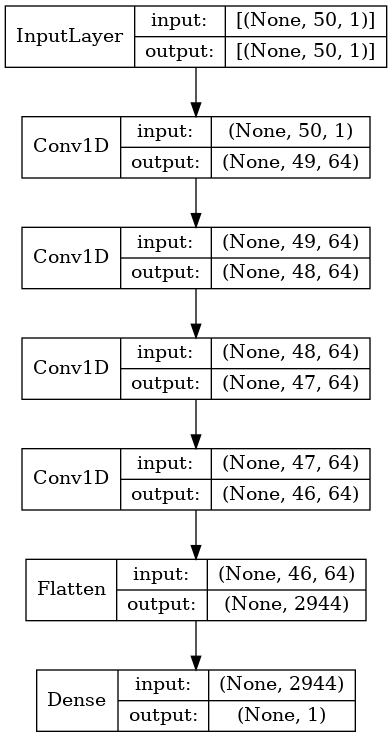

In [19]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [27]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [28]:
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [29]:
model.save_weights('deep-filter-model.h5')

In [30]:
losses = []

In [31]:
for i in range(1000):
    xs = np.array(range(0, n+1))
    ys = xs[1:]
    xs = (xs - np.min(xs)) / (np.max(xs) - np.min(xs)) - .5
    ys = (ys - np.min(ys)) / (np.max(ys) - np.min(ys)) - .5
    inputs = []
    outputs = []
    for j in range(n - window_size):
        an_input = ys[j:j+window_size]
        inputs.append(an_input)
        an_output = xs[j+window_size]
        outputs.append(an_output)
    the_inputs = np.array(inputs)
    history = model.fit(the_inputs.reshape(the_inputs.shape[0], the_inputs.shape[1], 1), np.array(outputs))
    losses.append(history.history['loss'][0])

30/30 [==============================] - 0s 4ms/step - loss: 2.3557e-08 - mse: 2.3557e-08


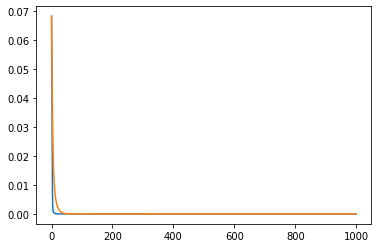

In [32]:
plt.plot(losses)
plt.plot(pd.Series(losses).ewm(alpha=.1).mean());

In [33]:
pred_outputs = []
true_outputs = []
for j in range(n - window_size):
    an_input = np.array([ys[j:j+window_size]])
    an_output = xs[j+window_size]
    true_outputs.append(an_output)
    pred_output = model.predict(np.reshape(an_input, (an_input.shape[0], an_input.shape[1], 1)))[0]
    pred_outputs.append(pred_output)

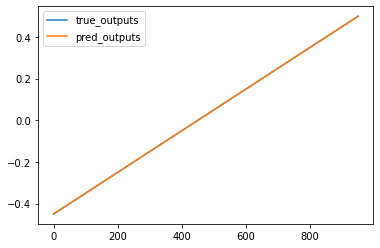

In [34]:
plt.plot(true_outputs, label='true_outputs')
plt.plot(pred_outputs, label='pred_outputs')
plt.legend();

Much better!

Now let's try this on the stochastic volatility model (with parameters fixed as above). We train the filter, as in (Zhang, 2020), using a MC simulation...

In [35]:
model.load_weights('deep-filter-model.h5')

In [36]:
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [37]:
losses = []

In [38]:
for i in range(1000):
    xs = generate_xs(parameters, n)
    ys = generate_ys(xs)
    xs = (xs - np.min(xs)) / (np.max(xs) - np.min(xs)) - .5
    ys = (ys - np.min(ys)) / (np.max(ys) - np.min(ys)) - .5
    inputs = []
    outputs = []
    for j in range(n - window_size):
        an_input = ys[j:j+window_size]
        inputs.append(an_input)
        an_output = xs[j+window_size]
        outputs.append(an_output)
    the_inputs = np.array(inputs)
    history = model.fit(the_inputs.reshape(the_inputs.shape[0], the_inputs.shape[1], 1), np.array(outputs))
    losses.append(history.history['loss'][0])

30/30 [==============================] - 0s 4ms/step - loss: 0.0127 - mse: 0.0127


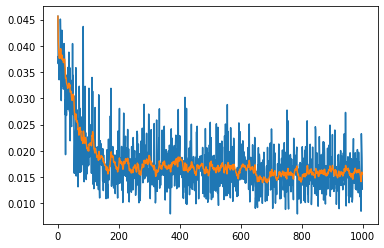

In [39]:
plt.plot(losses)
plt.plot(pd.Series(losses).ewm(alpha=.1).mean());

How does the model perform out-of-sample?

In [40]:
xs = generate_xs(parameters, n)
ys = generate_ys(xs)
xs = (xs - np.min(xs)) / (np.max(xs) - np.min(xs)) - .5
ys = (ys - np.min(ys)) / (np.max(ys) - np.min(ys)) - .5

In [41]:
pred_outputs = []
true_outputs = []
for j in range(n - window_size):
    an_input = np.array([ys[j:j+window_size]])
    an_output = xs[j+window_size]
    true_outputs.append(an_output)
    pred_output = model.predict(np.reshape(an_input, (an_input.shape[0], an_input.shape[1], 1)))[0]
    pred_outputs.append(pred_output)

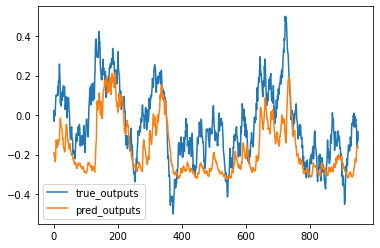

In [42]:
plt.plot(true_outputs, label='true_outputs')
plt.plot(pred_outputs, label='pred_outputs')
plt.legend();